# 🍽️ Amazon Fine Food Reviews Analysis  


Online platforms like Amazon collect millions of customer reviews.  
Reading them manually is impractical, so **Natural Language Processing (NLP)** techniques are used to automatically extract insights.

In this project, we analyze **real Amazon Fine Food Reviews** to:
- Group similar reviews using **clustering**
- Identify major themes in customer feedback
- Measure **customer sentiment**
- Visualize review structure
- Compare **TF-IDF vs Word2Vec** representations



## 📂 Dataset Description

We use the **Amazon Fine Food Reviews** dataset from Kaggle, which contains:
- Over **500,000** food-related product reviews
- Review text, ratings, summaries, and metadata

Due to the large size of the dataset, we randomly sample a subset of reviews to keep computation efficient.


In [1]:
!pip -q install kaggle wordcloud gensim textblob


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 73.7 MB/s eta 0:00:00


In [4]:
from pathlib import Path
import zipfile

zip_path = Path("/content/archive (1).zip")
extract_dir = Path("data")
extract_dir.mkdir(exist_ok=True)

if not zip_path.exists():
    raise FileNotFoundError(f"Zip file not found at: {zip_path}")

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)

print("✅ Extracted to:", extract_dir.resolve())


✅ Extracted to: /content/data


## 2) Locate and load the dataset CSV


We will:
- Search inside the extracted folder
- Find `Reviews.csv`
- Load it into pandas


In [6]:
import pandas as pd

csv_files = list(extract_dir.rglob("Reviews.csv"))
if not csv_files:
    # if it isn't exactly named Reviews.csv, show what's available
    all_csvs = list(extract_dir.rglob("*.csv"))
    print("CSV files found:", [str(x) for x in all_csvs][:20])
    raise FileNotFoundError("Could not find Reviews.csv. Check the printed CSV list above.")

csv_path = csv_files[0]
print("✅ Found CSV:", csv_path)

df_raw = pd.read_csv(csv_path)
df_raw.head()


✅ Found CSV: data/Reviews.csv


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## 3) Keep only the review text + sample for speed

This dataset can have hundreds of thousands of rows, which is slow for clustering.

We will:
- Use the `Text` column (full review)
- Drop missing reviews
- Randomly sample 5,000 reviews

In [7]:
if "Text" not in df_raw.columns:
    raise ValueError(f"'Text' column not found. Columns are: {df_raw.columns.tolist()}")

df = df_raw[["Text"]].dropna().rename(columns={"Text": "review"}).copy()

N = 5000
df = df.sample(n=min(N, len(df)), random_state=42).reset_index(drop=True)

print("✅ Reviews used:", len(df))
df.head()


✅ Reviews used: 5000


,review
0,Having tried a couple of other brands of glute...
1,My cat loves these treats. If ever I can't fin...
2,A little less than I expected. It tends to ha...
3,"First there was Frosted Mini-Wheats, in origin..."
4,and I want to congratulate the graphic artist ...


## 4) Clean the review text

Raw reviews contain punctuation, links, and random formatting.

We clean text by:
- Lowercasing everything
- Removing links
- Removing punctuation/numbers
- Removing extra spaces

This helps TF-IDF, clustering, and topic modeling.


In [8]:
import re

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_review"] = df["review"].astype(str).apply(clean_text)
df.head()


,review,clean_review
0,Having tried a couple of other brands of glute...,having tried a couple of other brands of glute...
1,My cat loves these treats. If ever I can't fin...,my cat loves these treats if ever i can t find...
2,A little less than I expected. It tends to ha...,a little less than i expected it tends to have...
3,"First there was Frosted Mini-Wheats, in origin...",first there was frosted mini wheats in origina...
4,and I want to congratulate the graphic artist ...,and i want to congratulate the graphic artist ...


## 5) Convert text into numbers using TF-IDF

Machine learning algorithms need numeric input.

TF-IDF creates a matrix where:
- each row = one review
- each column = a word
- values = importance of word in that review

We also remove common stopwords like "the", "and", "is".


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english", max_features=5000, min_df=5)
X_tfidf = tfidf.fit_transform(df["clean_review"])

X_tfidf.shape


(5000, 3721)

## 6) Try different values of K (number of clusters)

K-Means requires choosing how many clusters K we want.

We will test K from 2 to 8 and compute:
- **Silhouette Score** (higher is better clustering)
- **Inertia** (used in elbow method)

Then we choose the K with the best silhouette score.


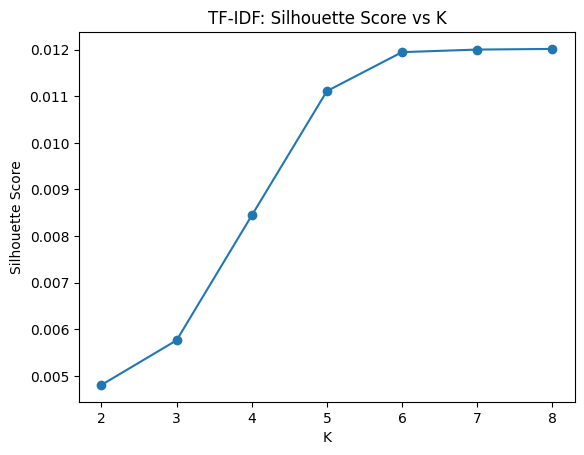

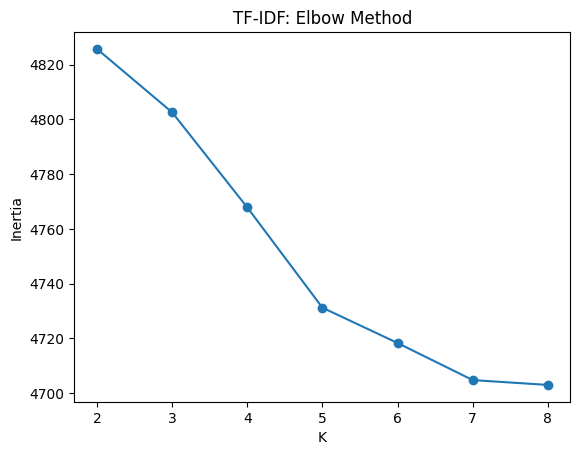

✅ Best K by silhouette score: 8


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = list(range(2, 9))
sil_scores = []
inertias = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_tfidf)
    sil_scores.append(silhouette_score(X_tfidf, labels))
    inertias.append(km.inertia_)

plt.figure()
plt.plot(k_values, sil_scores, marker="o")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("TF-IDF: Silhouette Score vs K")
plt.show()

plt.figure()
plt.plot(k_values, inertias, marker="o")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("TF-IDF: Elbow Method")
plt.show()

best_k_tfidf = k_values[int(np.argmax(sil_scores))]
print("✅ Best K by silhouette score:", best_k_tfidf)


## 7) Train K-Means with the best K

Now we fit K-Means with the chosen number of clusters - 8.
Each review gets a cluster label.


In [11]:
kmeans_tfidf = KMeans(n_clusters=best_k_tfidf, random_state=42, n_init="auto")
df["cluster_tfidf"] = kmeans_tfidf.fit_predict(X_tfidf)

df[["review", "cluster_tfidf"]].head()


,review,cluster_tfidf
0,Having tried a couple of other brands of glute...,2
1,My cat loves these treats. If ever I can't fin...,1
2,A little less than I expected. It tends to ha...,6
3,"First there was Frosted Mini-Wheats, in origin...",7
4,and I want to congratulate the graphic artist ...,6


## 8) Interpret clusters using top keywords

Clusters are just numbers unless we interpret them.

We inspect the cluster centers and print the words with the highest weights
to understand what each cluster is about.


In [12]:
feature_names = tfidf.get_feature_names_out()
centroids = kmeans_tfidf.cluster_centers_

def top_keywords(cluster_id, n=12):
    idx = centroids[cluster_id].argsort()[-n:][::-1]
    return [feature_names[i] for i in idx]

for c in range(best_k_tfidf):
    print(f"\nCluster {c} top keywords:")
    print(top_keywords(c, 12))



Cluster 0 top keywords:
['love', 'dogs', 'eat', 'good', 'bag', 'treat', 'just', 'loves', 'treats', 'little', 'buy', 'kids']

Cluster 1 top keywords:
['dog', 'food', 'cat', 'treats', 'loves', 'br', 'dogs', 'cats', 'eat', 'dry', 'like', 'treat']

Cluster 2 top keywords:
['like', 'taste', 'chocolate', 'flavor', 'good', 'sweet', 'sugar', 'just', 'really', 'chips', 'cookies', 'free']

Cluster 3 top keywords:
['coffee', 'cup', 'good', 'strong', 'like', 'br', 'flavor', 'bold', 'roast', 'smooth', 'cups', 'taste']

Cluster 4 top keywords:
['great', 'price', 'amazon', 'product', 'good', 'taste', 'buy', 'flavor', 'best', 'store', 'love', 'just']

Cluster 5 top keywords:
['tea', 'green', 'teas', 'br', 'taste', 'flavor', 'good', 'drink', 'like', 'love', 'iced', 'bags']

Cluster 6 top keywords:
['product', 'good', 'use', 'amazon', 'just', 'bought', 'used', 'time', 'ordered', 'buy', 'taste', 'like']

Cluster 7 top keywords:
['br', 'like', 'good', 'product', 'taste', 'just', 'flavor', 'great', 'amazo

## 9) Word Clouds per cluster

Word clouds give a quick visual summary of the most common words in each cluster.


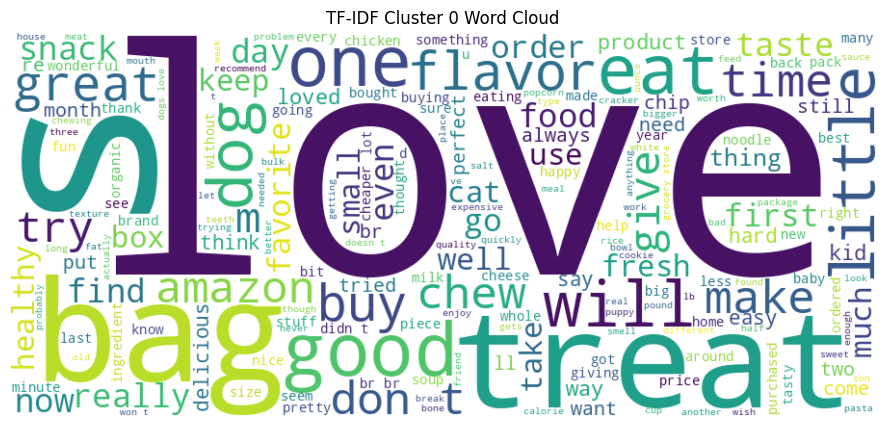

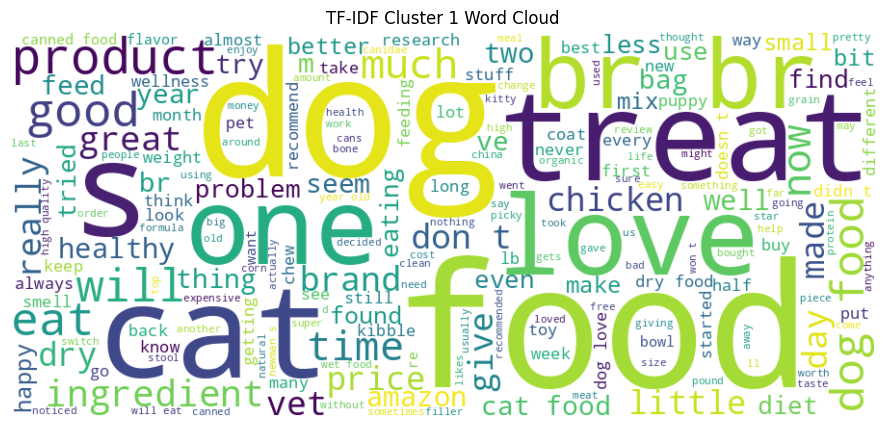

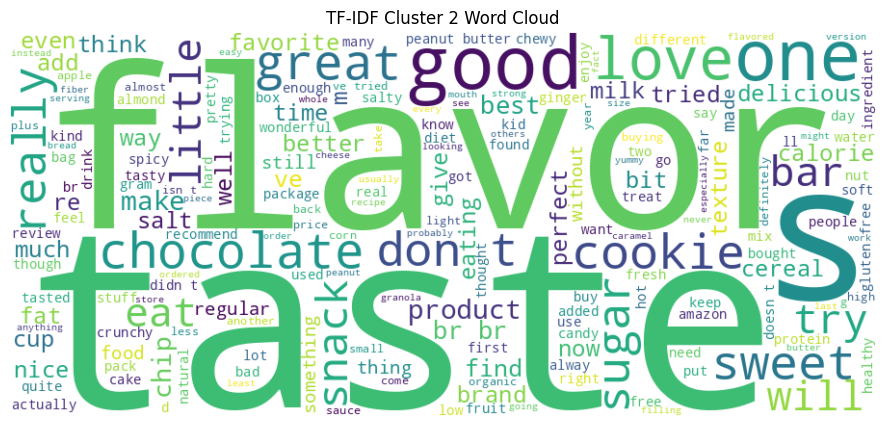

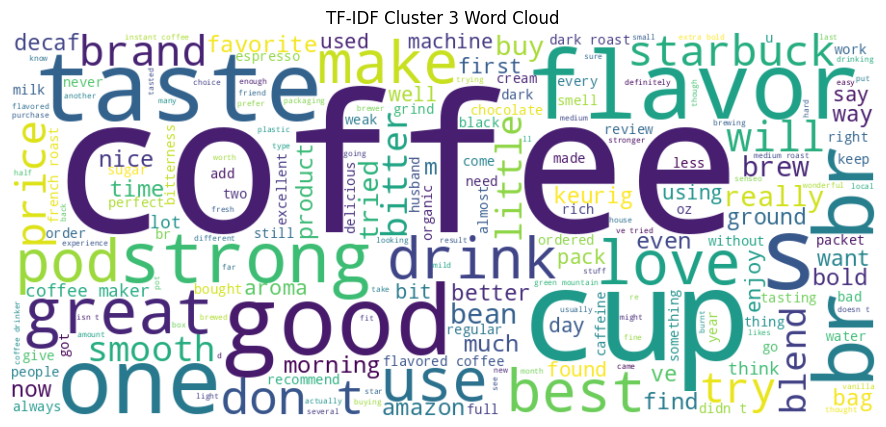

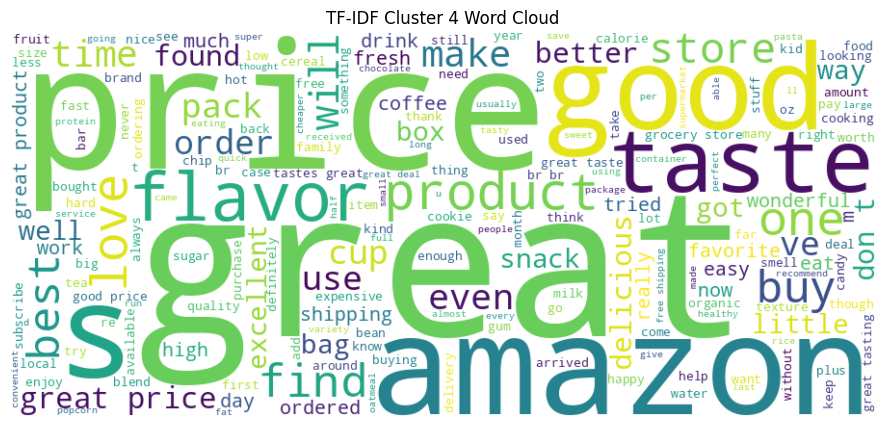

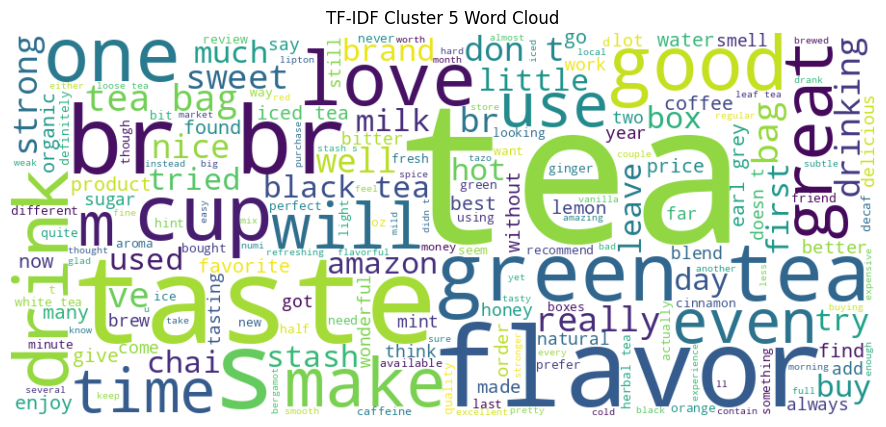

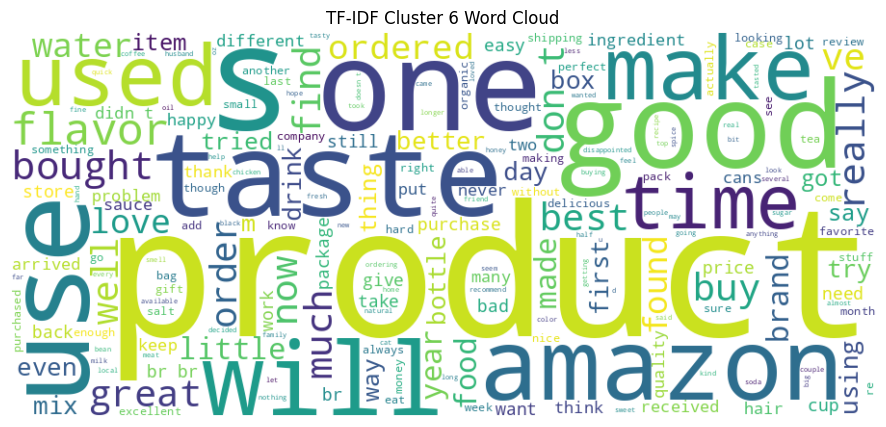

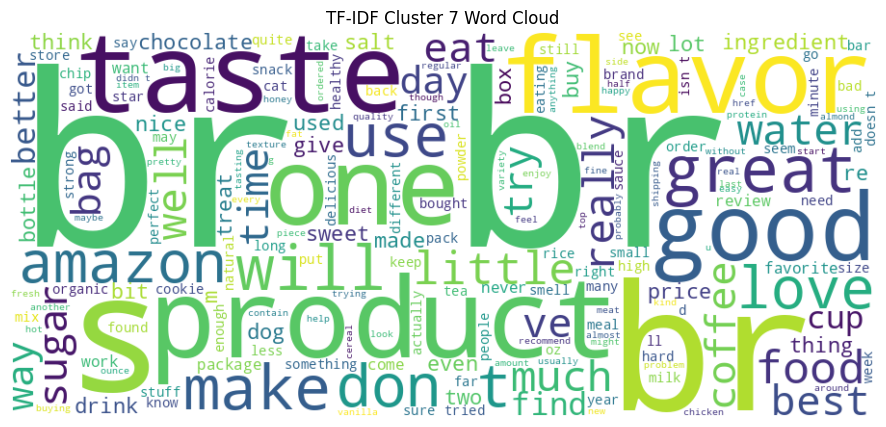

In [13]:
from wordcloud import WordCloud

def plot_wordcloud(text, title):
    wc = WordCloud(width=900, height=400, background_color="white").generate(text)
    plt.figure(figsize=(12,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

for c in range(best_k_tfidf):
    cluster_text = " ".join(df[df["cluster_tfidf"] == c]["clean_review"].tolist())
    plot_wordcloud(cluster_text, f"TF-IDF Cluster {c} Word Cloud")


## 10) Visualize clusters using PCA

TF-IDF vectors have thousands of dimensions.
PCA reduces them to 2 dimensions so we can plot clusters.


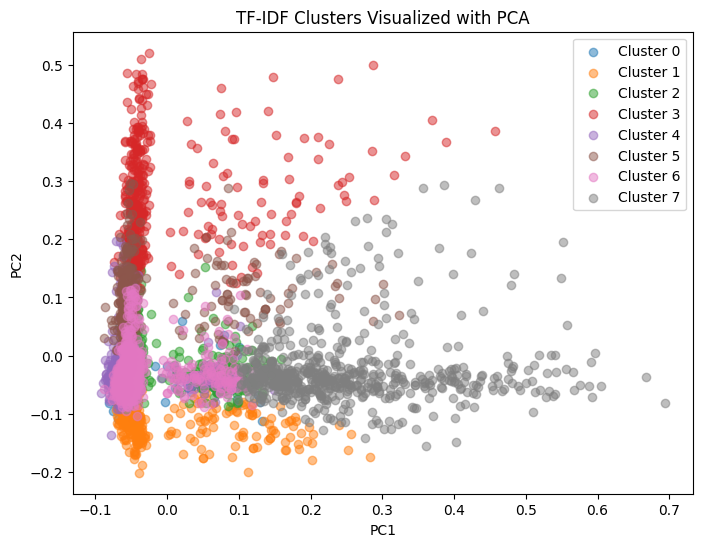

In [14]:
from sklearn.decomposition import PCA

X_2d = PCA(n_components=2, random_state=42).fit_transform(X_tfidf.toarray())

plt.figure(figsize=(8,6))
for c in range(best_k_tfidf):
    pts = X_2d[df["cluster_tfidf"] == c]
    plt.scatter(pts[:,0], pts[:,1], alpha=0.5, label=f"Cluster {c}")

plt.title("TF-IDF Clusters Visualized with PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


## 11) Sentiment analysis

We compute sentiment polarity using TextBlob:
- -1 = very negative
- 0 = neutral
- +1 = very positive

Then we compare average sentiment across clusters.


In [15]:
from textblob import TextBlob

df["sentiment"] = df["review"].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
df.groupby("cluster_tfidf")["sentiment"].mean().sort_values()


,sentiment
cluster_tfidf,
1,0.161420
6,0.199942
7,0.200869
5,0.243524
2,0.246083
0,0.261769
3,0.280008
4,0.417977


## 12) Topic Modeling with LDA

LDA finds hidden topics in text.
Each topic is represented by a list of important words.

LDA uses word counts, so we use CountVectorizer instead of TF-IDF.


In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

count_vec = CountVectorizer(stop_words="english", max_features=5000, min_df=5)
X_count = count_vec.fit_transform(df["clean_review"])

n_topics = 6
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X_count)

topic_words = count_vec.get_feature_names_out()

for i, topic in enumerate(lda.components_):
    top_idx = topic.argsort()[-12:][::-1]
    words = [topic_words[j] for j in top_idx]
    print(f"Topic {i}: {words}")


Topic 0: ['br', 'chips', 'sauce', 'flavor', 'salt', 'good', 'like', 'taste', 'bag', 'just', 'best', 'fat']
Topic 1: ['br', 'food', 'dog', 'eat', 'like', 'cat', 'product', 'good', 'just', 'day', 'cats', 'really']
Topic 2: ['br', 'use', 'great', 'product', 'oil', 'good', 'love', 'free', 'best', 'just', 've', 'used']
Topic 3: ['coffee', 'tea', 'br', 'cup', 'good', 'like', 'flavor', 'taste', 'strong', 'cups', 'great', 'just']
Topic 4: ['product', 'amazon', 'good', 'price', 'just', 'great', 'like', 'br', 'time', 'buy', 'order', 'love']
Topic 5: ['like', 'taste', 'tea', 'flavor', 'good', 'br', 'chocolate', 'great', 'just', 'sweet', 'sugar', 'water']


## 13) Word2Vec embeddings and clustering

TF-IDF clusters by shared keywords.
Word2Vec captures semantic meaning (words that appear in similar contexts).

We:
1. Train Word2Vec on review tokens
2. Convert each review into an average embedding
3. Cluster embeddings with K-Means
4. Compare silhouette scores vs TF-IDF


In [17]:
from gensim.models import Word2Vec
import numpy as np

tokens = df["clean_review"].apply(lambda x: [w for w in x.split() if len(w) > 2]).tolist()

w2v = Word2Vec(
    sentences=tokens,
    vector_size=100,
    window=5,
    min_count=3,
    workers=4,
    sg=1,
    seed=42
)

def review_vector(words, model):
    vecs = [model.wv[w] for w in words if w in model.wv]
    if len(vecs) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0)

X_w2v = np.vstack([review_vector(ws, w2v) for ws in tokens])
X_w2v.shape


(5000, 100)

## 14) Choose K and cluster Word2Vec vectors


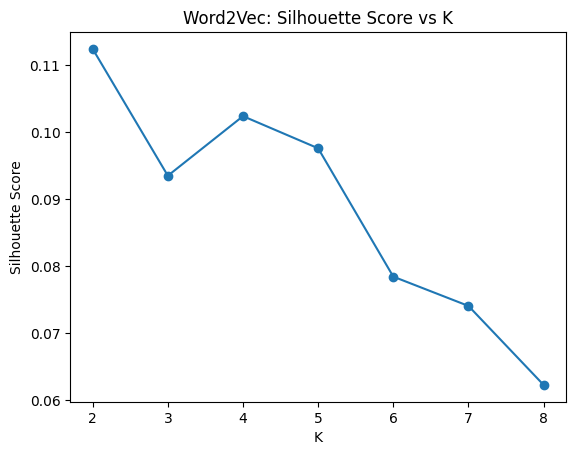

✅ Best K (Word2Vec): 2


In [18]:
from sklearn.metrics import silhouette_score

sil_scores_w2v = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_w2v)
    sil_scores_w2v.append(silhouette_score(X_w2v, labels))

plt.figure()
plt.plot(k_values, sil_scores_w2v, marker="o")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Word2Vec: Silhouette Score vs K")
plt.show()

best_k_w2v = k_values[int(np.argmax(sil_scores_w2v))]
print("✅ Best K (Word2Vec):", best_k_w2v)

kmeans_w2v = KMeans(n_clusters=best_k_w2v, random_state=42, n_init="auto")
df["cluster_w2v"] = kmeans_w2v.fit_predict(X_w2v)


## 15) Final comparison: TF-IDF vs Word2Vec


In [19]:
comparison = pd.DataFrame({
    "Method": ["TF-IDF", "Word2Vec"],
    "Best K": [best_k_tfidf, best_k_w2v],
    "Best Silhouette": [max(sil_scores), max(sil_scores_w2v)]
})
comparison


,Method,Best K,Best Silhouette
0,TF-IDF,8,0.012013
1,Word2Vec,2,0.112471


## 16) Show example reviews from each TF-IDF cluster




In [20]:
def show_cluster_examples(label_col, cluster_id, n=3):
    subset = df[df[label_col] == cluster_id].sample(
        n=min(n, (df[label_col] == cluster_id).sum()),
        random_state=42
    )
    for r in subset["review"].tolist():
        print("-", r[:300].replace("\n", " "), "...\n")

for c in range(best_k_tfidf):
    print("\n==============================")
    print("TF-IDF Cluster", c)
    show_cluster_examples("cluster_tfidf", c, 3)



TF-IDF Cluster 0
- I am a mom of 3 kids. My youngest is always on the go as we take her older siblings to their sports practices and games. I was so happy to find a non-breakable, organic, BPA free food for her. I keep these in her diaper bag so when she is hungry, she always has a healthy meal. She likes them all but ...

- I am a white, white Maltese. Before Mommy started giving me the Pro-Treat Beef Liver, freeze dried, my tears were black and stained my face. With my enjoying one treat per day, my beautiful white face is so beautiful.  I eat only natural, non colored food and drink spring water. But Mommy says the t ...

- These were recommended by a cardiac rehab center to lower cholesterol.  I was skeptical but my total cholesterol had risen above 200 and I didn't want to take medicine.  Started taking the chews the end of Jan. 09 two per day for a couple months, then upped it to 4 per day for a month and a half.  J ...


TF-IDF Cluster 1
- Within days of starting a routine of o

# ✅ Conclusion

In this project, I analyzed a real subset of the **Amazon Fine Food Reviews** dataset and built an end-to-end NLP pipeline to discover themes in customer feedback.

### What I found

**1) TF-IDF + K-Means worked best with K = 8**
Using silhouette score, the best clustering result occurred at **K = 8**, meaning the review text naturally separated into eight reasonably distinct groups. Each cluster had interpretable keywords that describe the main theme:

- **Cluster 0**: *Family/pets/general enjoyment* (keywords like: love, dogs, kids, treats)  
- **Cluster 1**: *Pet food / dog & cat product reviews* (dog, food, cat, treats, dry)  
- **Cluster 2**: *Sweet snacks and flavor reviews* (taste, chocolate, sweet, sugar, chips, cookies)  
- **Cluster 3**: *Coffee-specific reviews* (coffee, cup, roast, strong, bold, smooth)  
- **Cluster 4**: *Price/value and buying on Amazon* (great, price, amazon, best, buy, store)  
- **Cluster 5**: *Tea reviews (especially green tea)* (tea, green, bags, iced, drink)  
- **Cluster 6**: *General product usage + ordering/experience* (use, bought, ordered, time, used)  
- **Cluster 7**: *General product satisfaction words (less specific cluster)* (good, taste, flavor, great, amazon)

Even though some clusters overlap in PCA (which is expected when reducing thousands of TF-IDF dimensions down to just 2), the keyword lists and example reviews show that the clusters are still meaningful.

---

**2) Sentiment analysis showed most clusters are overall positive**
Using TextBlob polarity, all clusters had positive average sentiment, but the positivity level differed:

- The **most positive cluster** was **Cluster 4 (~0.418)**, which matches its theme of *good price/value and satisfaction with purchasing*.
- The **least positive cluster** was **Cluster 1 (~0.161)**, which aligns with more neutral, factual pet-food discussion rather than strongly emotional reviews.

Overall, the sentiment results suggest the sampled reviews are skewed toward positive customer feedback (which is common in many product review datasets).

---

**3) LDA Topic Modeling confirmed the same major themes**
LDA topics matched the clustering themes closely. For example:
- A topic focused on **pets (dog/cat food)**
- A topic focused on **coffee/tea**
- A topic focused on **Amazon/price/order**
- A topic focused on **taste/flavor/snacks (chips, chocolate, sweet)**

This agreement between clustering and topic modeling increased confidence that the discovered themes are real patterns in the dataset.

---

**4) Word2Vec clustering preferred fewer clusters (K = 2)**
When I represented reviews using Word2Vec (semantic embeddings), the best silhouette score occurred at **K = 2**.  
This suggests Word2Vec grouped reviews into broader, more general semantic buckets rather than many fine-grained product categories. TF-IDF produced more detailed topical separation in this case.

---

## Final Takeaway

This notebook demonstrates that **TF-IDF + K-Means (K=8)** is effective for finding specific review themes such as **pets, coffee, tea, snacks, and price/value**, while **Word2Vec** tends to form more general clusters on this dataset sample. Combining clustering, topic modeling, and sentiment analysis provides a more complete understanding of customer feedback patterns.
